# CNN-based regression of drop impact parameters

## 1.0 Preparing the enviroment

In [1]:
#!pip install ipython-autotime
#!pip install opencv-python
#!pip install tensorflow_addons
%load_ext autotime

time: 167 µs (started: 2023-06-23 14:30:52 +02:00)


In [2]:
#Importing the necessary libraries
import math
import trimesh
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from glob import glob
from PIL import Image
import cv2
import json
from os import walk
from tqdm import tqdm
from datetime import datetime
import multiprocessing as mp

time: 1.51 s (started: 2023-06-23 14:30:52 +02:00)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing as pp

time: 94.3 ms (started: 2023-06-23 14:30:54 +02:00)


In [4]:
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from tensorflow_addons.metrics import RSquare
from keras import optimizers, models, layers, regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Input, Lambda, Flatten
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from keras.utils.np_utils import to_categorical

tf.__version__

2023-06-23 14:30:54.318393: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-23 14:30:54.362639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 14:30:55.407809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/kit/stud/uwztf/.local/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode u

'2.12.0'

time: 2.61 s (started: 2023-06-23 14:30:54 +02:00)


## 2.0 Loading the data

In [5]:
# Define a helper function that takes a subdirectory name and returns the image and label
def process_subdirectory(path):
    size=512
    obj_path = path[0]
    subdirectory = path[1]
    images = None
    labels = None
    readed = lambda image_name: np.asarray(Image.open(image_name).convert("RGB"))
    random_number=np.random.randint(0,36)*10
    for i_image in os.listdir(obj_path+'/'+subdirectory):
        PATH = os.path.join(obj_path+'/'+subdirectory,i_image)
        if i_image.endswith('png'):
            if i_image==(str(random_number)+'_0_00.png'):        
                #read a random representation of each droplet
                img_loop = readed(PATH)
                # Resizing image if needed:
                # img_loop = cv2.resize(img_loop, (size,size))
                # Normalizing the colors
                #-----------------------------------------------------------------------
                # RGB (Red, Green, Blue) are 8 bit each and the range for each individual 
                # colour is 0-255 (2^8 = 256). By dividing by 255, the 0-255 range is converted to
                # a range between 0.0-1.0.
                #-----------------------------------------------------------------------
                images = np.array(img_loop)/255.
                labels = subdirectory+'/'+i_image.replace('.png','')
    return images, labels

# Creating a function to read the images from the files:
def image_reader(obj_path):      
    images = []
    labels = []
    # Create a pool 
    pool = mp.Pool(mp.cpu_count())
    print(f"Using all {mp.cpu_count()} processor cores to parallelize task.")
    # Use imap to apply your function to each subdirectory and get an iterator of results
    subdirs = os.listdir(obj_path)
    results = tqdm(pool.imap(process_subdirectory, zip([obj_path] * len(subdirs), subdirs)), total = len(subdirs))
    # Iterate over the results and append them to the output lists
    for image, label in results:
        images.append(image)
        labels.append(label)
    return images, labels

time: 1.06 ms (started: 2023-06-23 14:30:56 +02:00)


In [6]:
# Reading the images
image_data, label_data = image_reader('/pfs/work7/workspace/scratch/oy0026-DDE2_droplet/RENDER/')
image_data = np.array(image_data)
label_data = np.array(label_data)
print(image_data.shape)

(1479, 512, 512, 3)
time: 18.7 s (started: 2023-06-23 14:30:56 +02:00)


In [7]:
print(label_data)

['0588/0_0_00' 'droplet0_387/0_0_00' 'droplet0_370/0_0_00' ...
 'droplet0_379/0_0_00' '0665/0_0_00' '0131/0_0_00']
time: 647 µs (started: 2023-06-23 14:31:15 +02:00)


In [8]:
# Sorting the data, as labels show that data is unsorted so far
sortedIndices = np.argsort(label_data)
sorted_labels = label_data[sortedIndices]
sorted_images = image_data[sortedIndices]

time: 3.13 s (started: 2023-06-23 14:31:15 +02:00)


In [9]:
print(sorted_labels)

['0001/0_0_00' '0002/0_0_00' '0003/0_0_00' ... 'droplet0_97/0_0_00'
 'droplet0_98/0_0_00' 'droplet0_99/0_0_00']
time: 555 µs (started: 2023-06-23 14:31:18 +02:00)


In [10]:
#Read y_data from json file (contains data extracted from .obj files with trimesh script)
def read_json_data(filename):
    f = open(filename)
    data = json.load(f)
    return data

time: 10.7 ms (started: 2023-06-23 14:31:18 +02:00)


In [11]:
# For access over Visual Studio code, one has to move the directory to the git folder.
if os.getcwd().split("/")[-1] != "dde2_project":
    os.chdir("./dde2_project")

time: 3.02 ms (started: 2023-06-23 14:31:18 +02:00)


In [12]:
labeled_y_data = read_json_data('data.json')
y_data=[]
for key, value in labeled_y_data.items(): # keys are already sorted in json 
    y_data.append(value)
y_data=np.array(y_data)
print(y_data.shape)

(1479, 6)
time: 8.13 ms (started: 2023-06-23 14:31:18 +02:00)


In [13]:
print(y_data[0]) #Shape is 6 because Volume, Area, Contact Angle and the 3 Coordinates of the areatric Centre are included.

[-6.10399648e+05  3.48113614e+04  1.20883888e+01  2.16657502e-06
  5.17007097e+01 -2.54537324e-06]
time: 1.05 ms (started: 2023-06-23 14:31:18 +02:00)


## 3.0 Data Exploration and Feature Engineering

In [14]:
#for easier readability put y_data in Pandas Dataframe and add feature names
y_data=pd.DataFrame(y_data)
y_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1479 entries, 0 to 1478
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1479 non-null   float64
 1   1       1479 non-null   float64
 2   2       1325 non-null   float64
 3   3       1479 non-null   float64
 4   4       1479 non-null   float64
 5   5       1479 non-null   float64
dtypes: float64(6)
memory usage: 69.5 KB
time: 8.25 ms (started: 2023-06-23 14:31:18 +02:00)


In [15]:
y_data.rename(columns = {0:'Volume', 1:'Area', 2:'Contact Angle', 3:'x centroid' , 4:'y centroid' , 5:'z centroid'}, inplace = True)

time: 1.1 ms (started: 2023-06-23 14:31:18 +02:00)


In [16]:
y_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1479 entries, 0 to 1478
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Volume         1479 non-null   float64
 1   Area           1479 non-null   float64
 2   Contact Angle  1325 non-null   float64
 3   x centroid     1479 non-null   float64
 4   y centroid     1479 non-null   float64
 5   z centroid     1479 non-null   float64
dtypes: float64(6)
memory usage: 69.5 KB
time: 7.64 ms (started: 2023-06-23 14:31:18 +02:00)


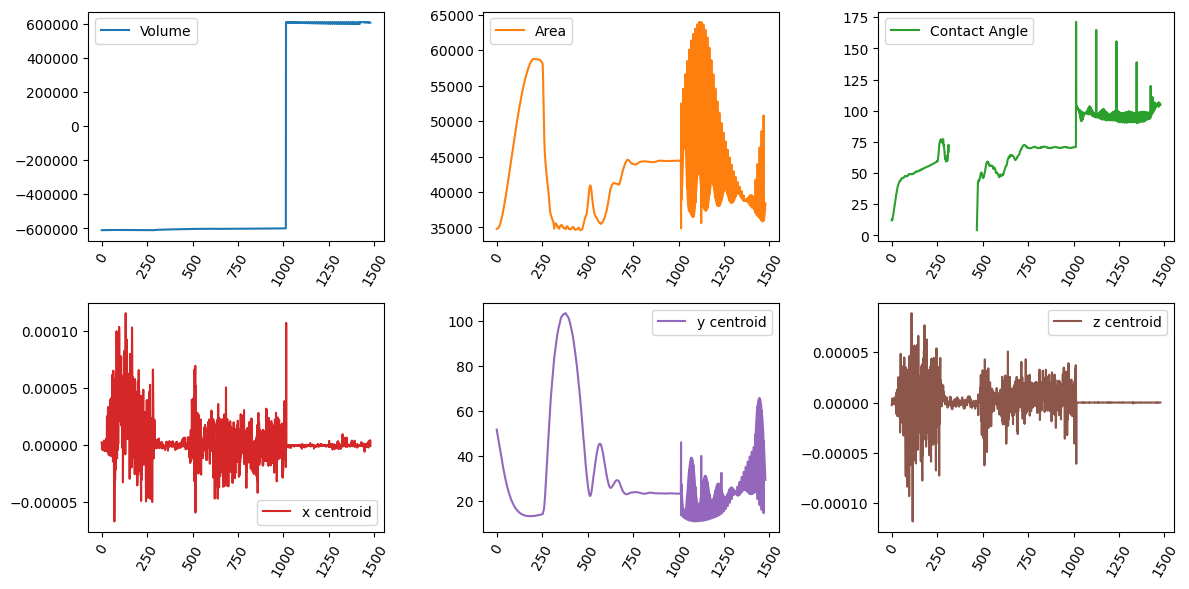

time: 797 ms (started: 2023-06-23 14:31:18 +02:00)


In [17]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)
y_data.plot(ax = axes, subplots = True, rot = 60)
plt.show()

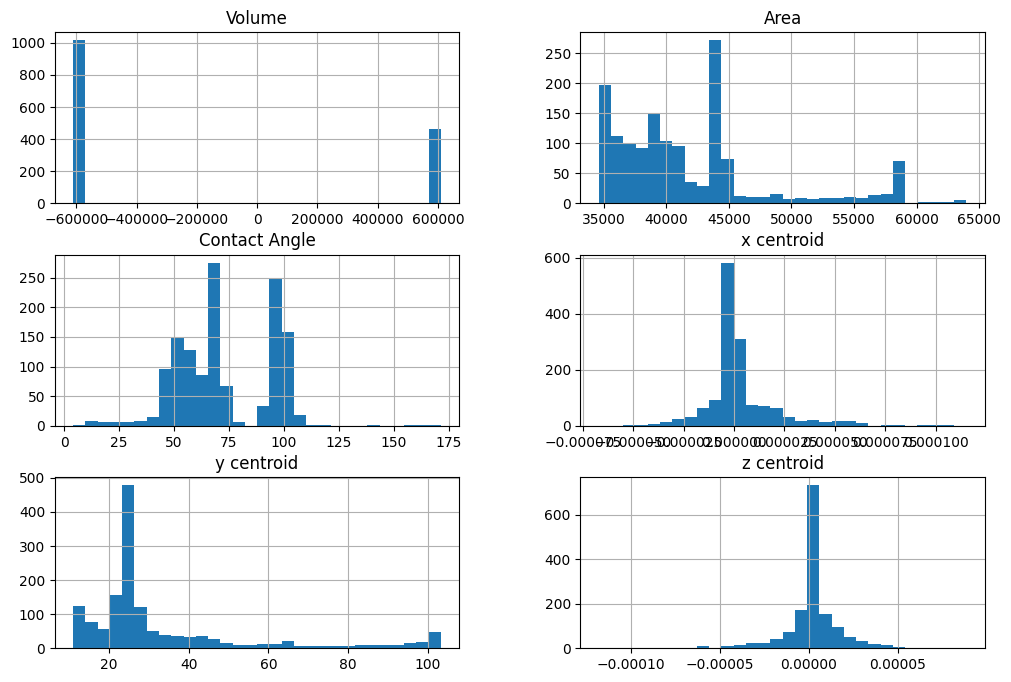

time: 920 ms (started: 2023-06-23 14:31:19 +02:00)


In [18]:
y_data.hist(bins=30, figsize=(12,8))
plt.show()

> Coordinate axes are wrong, y axis should be z axis
> From the x and z coordinates we can see, that the area of the droplets in sum seems to be rotationally symmetrical
> Therefore the x and z coordinates do not contain relevant information for the 3D reconstruction

In [19]:
# As we have seen above some volumes are negative, for the moment the absolute value is being taken 
# Reason for negative volume should be investigated!
y_data['Volume'] = np.abs(y_data['Volume'])
y_data['Volume'].value_counts()

610399.648118    1
599985.966817    1
599901.252631    1
599910.416775    1
599919.652702    1
                ..
603313.023031    1
603335.009368    1
603360.952753    1
603389.153670    1
605039.659185    1
Name: Volume, Length: 1479, dtype: int64

time: 4.36 ms (started: 2023-06-23 14:31:20 +02:00)


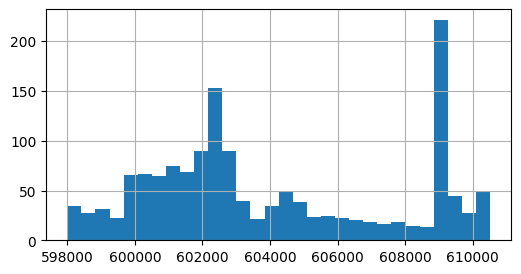

time: 128 ms (started: 2023-06-23 14:31:20 +02:00)


In [20]:
y_data['Volume'].hist(bins=30, figsize=(6,3))
plt.show()

In [21]:
# check the uniqueness of the dataset
distinctCounter = y_data.apply(lambda x: len(x.unique()))
print(distinctCounter)

Volume           1479
Area             1479
Contact Angle    1326
x centroid       1479
y centroid       1479
z centroid       1479
dtype: int64
time: 2.02 ms (started: 2023-06-23 14:31:20 +02:00)


In [22]:
y_data.isna().sum()

Volume             0
Area               0
Contact Angle    154
x centroid         0
y centroid         0
z centroid         0
dtype: int64

time: 4.53 ms (started: 2023-06-23 14:31:20 +02:00)


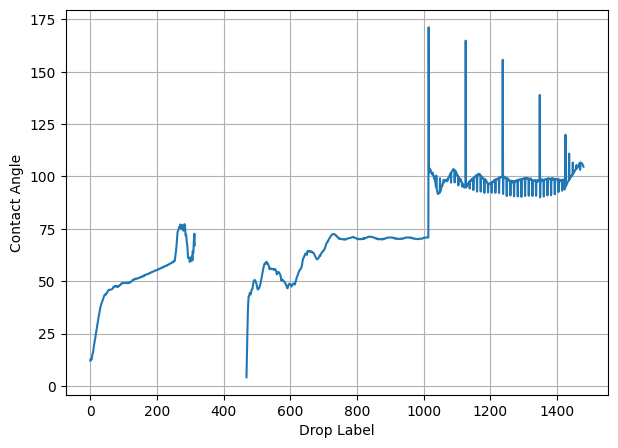

time: 129 ms (started: 2023-06-23 14:31:20 +02:00)


In [23]:
#As there are some NaN values in the Contact Angle let's have a closer look at that feature
mpl.rcParams['figure.figsize'] = [7.0, 5.0]
plt.grid(True)
plt.plot(np.linspace(0,len(y_data),len(y_data)), y_data["Contact Angle"])
plt.xlabel('Drop Label')
plt.ylabel('Contact Angle')
plt.show()

Int64Index([314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
            ...
            458, 459, 460, 461, 462, 463, 464, 465, 466, 467],
           dtype='int64', length=154)


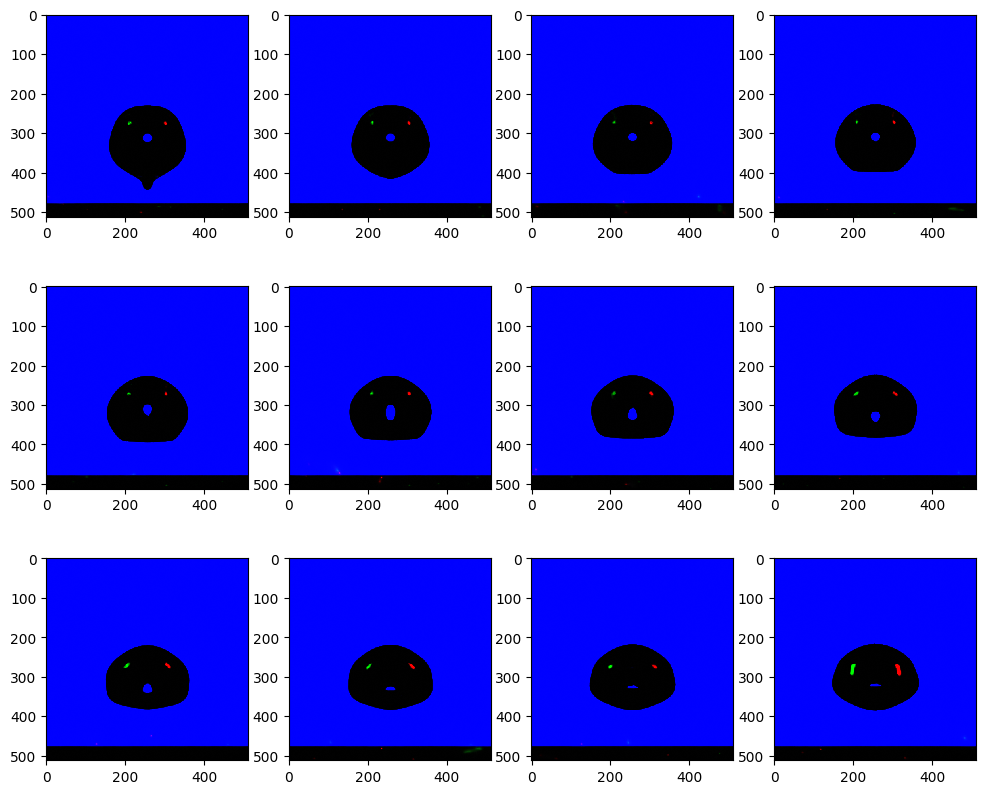

time: 1.22 s (started: 2023-06-23 14:31:20 +02:00)


In [24]:
# A closer look some of the images which have contact angle nan
mpl.rcParams['figure.figsize'] = [12.0, 12.0]
nan_angle_bool = y_data['Contact Angle'].isna()
nan_angle_indices = y_data[nan_angle_bool].index
nan_angle_filenames = sorted_labels[y_data['Contact Angle'].isna()]
print((nan_angle_indices))
fig=plt.figure(figsize=(12, 10))
for i in range(1, 12 +1):
    ax = fig.add_subplot(3, 4, i)
    plt.imshow(sorted_images[nan_angle_indices[i]], interpolation='nearest')
plt.show()
mpl.rcParams['figure.figsize'] = [7.0, 5.0]

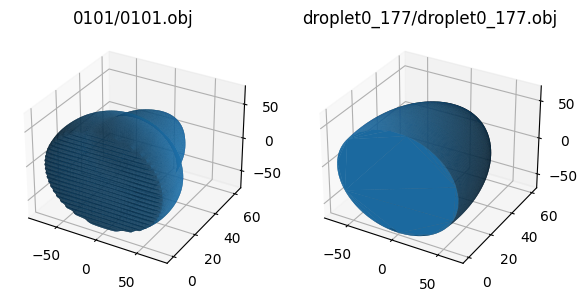

time: 11.4 s (started: 2023-06-23 14:31:21 +02:00)


In [25]:
obj_path ='/pfs/work7/workspace/scratch/oy0026-DDE2_droplet/OBJ/'

filenames = []
for (dirpath, dirnames, file_name) in walk(obj_path):
    for dirname in dirnames:
        for (dirpath, dirnames, file_name) in walk(obj_path+dirname):
            filenames.append(dirname+'/'+file_name[0])
    break
filenames = sorted(filenames)

fig = plt.figure()
display3Dlist = [100,1100]
for i in range(1,3):
    mesh = trimesh.load_mesh(os.path.join(obj_path, filenames[display3Dlist[i-1]]))
    ax = fig.add_subplot(1, 2, i, projection='3d')
    ax.set_title(filenames[display3Dlist[i-1]])
    ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], mesh.vertices[:,2], triangles=mesh.faces)
plt.show()

In [26]:
# We see that a contact angle NaN appears if the droplet has no contact to the ground, therefore for the moment 
# let's encode the NaN values as -1
y_data["Contact Angle"][nan_angle_indices]=-1
y_data["Contact Angle"].value_counts()

-1.000000      154
 12.088389       1
 95.935493       1
 91.616875       1
 92.068249       1
              ... 
 48.354089       1
 48.078439       1
 47.748439       1
 46.991324       1
 104.645713      1
Name: Contact Angle, Length: 1326, dtype: int64

time: 3.81 ms (started: 2023-06-23 14:31:33 +02:00)


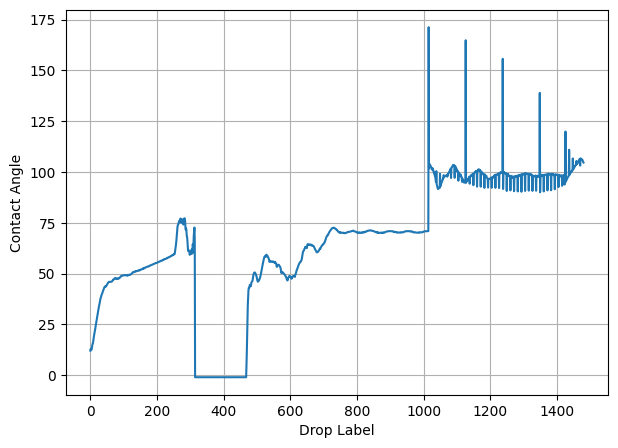

time: 135 ms (started: 2023-06-23 14:31:33 +02:00)


In [27]:
#Lets see the updated plot:
plt.grid(True)
plt.plot(np.linspace(0,len(y_data),len(y_data)), y_data["Contact Angle"])
plt.xlabel('Drop Label')
plt.ylabel('Contact Angle')
plt.show()

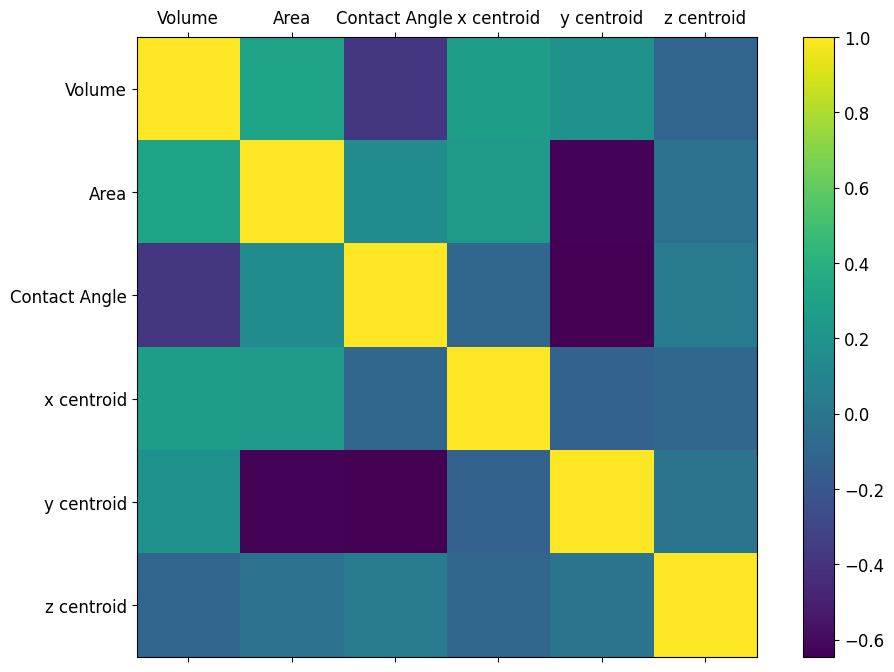

time: 211 ms (started: 2023-06-23 14:31:33 +02:00)


In [28]:
# Correlation matrix
correlationMatrix = pd.DataFrame(y_data).corr() 

f = plt.figure(figsize=(12, 8))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(y_data.shape[1]), y_data.columns, fontsize=12, rotation=0)
plt.yticks(range(y_data.shape[1]), y_data.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.show()

## 4.0 Train-Test-Split

In [29]:
X, y = shuffle(sorted_images, y_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1331, 512, 512, 3) (148, 512, 512, 3)
(1331, 6) (148, 6)
time: 6.27 s (started: 2023-06-23 14:31:33 +02:00)


## 5.0 CNNs for single output predictions

In [30]:
def build_CNN_single_output():
    # input array shape for the network:
    input_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]
    #Here we will use Sequential API like we did in MLP
    model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform"),
    MaxPooling2D((2, 2)),
    Flatten(),
    
    # Dense(6, activation='relu', kernel_initializer="he_uniform"),
    Dense(1, activation="linear")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = "mse", metrics=["mae", RSquare()]) 

    return model

time: 742 µs (started: 2023-06-23 14:31:39 +02:00)


In [31]:
#Looking at the graph:
build_CNN_single_output().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 128)      0

2023-06-23 14:31:40.675217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30917 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [32]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

time: 361 µs (started: 2023-06-23 14:31:41 +02:00)


In [33]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 150
batch_size = 4

time: 9.37 ms (started: 2023-06-23 14:31:41 +02:00)


### 5.1 Plotting functions

In [34]:
# Folder Name for storing plots
folder_name = datetime.now().strftime('%Y_%m_%d %Hh %M')

time: 2.81 ms (started: 2023-06-23 14:31:41 +02:00)


In [35]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history, title, save_results):
    #We will omit the first 0 points for a better visualization:
    plt.plot(history['epoch'][0:],history['loss'][0:], "k--", linewidth=1.5, label="Training")
    plt.plot(history['epoch'][0:],history['val_loss'][0:], "b-.", linewidth=1.5, label="Validation")
    plt.legend()
    # plt.ylim(1,100)
    plt.yscale("log")
    plt.xlabel("Epochs"),  plt.ylabel("Loss")
    if(save_results): 
        if(os.path.exists(f'plots/{folder_name}') == False): os.mkdir(f'plots/{folder_name}')
    if(save_results): plt.savefig(f'plots/{folder_name}/{title}.svg', dpi=300, format='svg', transparent=False) # , edgecolor='w', facecolor='w'

time: 1.52 ms (started: 2023-06-23 14:31:41 +02:00)


In [36]:
def plotting(y, y_pred, y_label=f'Volume V', save_results=False):
    
    title = f"predicted {y_label.split(' ')[0]} vs test data {y_label.split(' ')[0]}"
    
    fig, ax = plt.subplots()

    ax.plot(y, label=f"true {y_label.split(' ')[0]}", lw=1)
    ax.plot(y_pred, label=f"predicted {y_label.split(' ')[0]}", lw=1)
    
    ax.set_xlabel('')
    ax.set_ylabel(y_label)
    ax.legend(loc='upper right', shadow=False, fancybox=False, facecolor='white', edgecolor='black')
    ax.set_title(title)
    
    if(save_results): 
        if(os.path.exists(f'plots/{folder_name}') == False):
            os.mkdir(f'plots/{folder_name}')
    if(save_results): plt.savefig(f'plots/{folder_name}/{title}.svg', dpi=300, format='svg', transparent=False) # , edgecolor='w', facecolor='w'

time: 999 µs (started: 2023-06-23 14:31:41 +02:00)


In [37]:
# creating a pandas df to store the results
column_labels= ['Volume single', 'Volume multi', 
                'Area single', 'Area multi', 
                'Contact Angle single' ,'Contact Angle multi', 
                'y centroid single', 'y centroid multi']
score_df=pd.DataFrame(columns=column_labels)


time: 3.41 ms (started: 2023-06-23 14:31:41 +02:00)


In [38]:
#Calculating evaluation metrics: 
def print_scores (y_predicted, name):
    volume_scores = []

    volume_scores.append(r2_score(y_test[name].values, y_predicted))
    volume_scores.append(mean_absolute_error(y_test[name].values, y_predicted))
    volume_scores.append(mean_squared_error(y_test[name].values, y_predicted))

    print(f"{name} R²:  {volume_scores[0] * 100:10.2f}%")
    print(f"{name} MAE:  {volume_scores[1]:10.2f}")
    print(f"{name} MSE:  {volume_scores[2]:10.2f}")

    score_df[f"{name} single"] = np.array(volume_scores).T
    score_df.index = ["R²", "MAE", "MSE"]


time: 1.46 ms (started: 2023-06-23 14:31:41 +02:00)


In [39]:
#Visualization of the accuracy:
def plot_accuracy (y_pred, name):
    a = plt.axes(aspect='equal')
    plt.scatter(y_test[name].values, y_pred )
    plt.xlabel(f'True {name}')
    plt.ylabel(f'Predicted {name}')
    plt.title(name)
    lims=[min(y_test[name].values.min(), y_pred.min()), max(y_test[name].values.max(), y_pred.max())]
    plt.xlim(lims), plt.ylim(lims)
    plt.plot(lims, lims)

time: 1.52 ms (started: 2023-06-23 14:31:41 +02:00)


In [40]:
# Printing a dataframe as a table
def print_stats(df):
    fig, ax = plt.subplots(1,1)
    fig.set_figwidth(12)
    fig.set_figheight(4)
    fig.set_dpi(300)
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index,loc="center", bbox = [0,0,1,1])
    plt.show()

time: 1.65 ms (started: 2023-06-23 14:31:41 +02:00)


### 5.2 Volume prediction

In [41]:
#We will first create the object to feed fit() method:
myCheckpoint_volume = keras.callbacks.ModelCheckpoint("best_model_volume_prediction.h5", save_best_only=True)

time: 281 µs (started: 2023-06-23 14:31:41 +02:00)


In [42]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_CNN_volume = build_CNN_single_output()

#Training step: Trains the model in silent mode (verbose = 0)
history_volume = model_CNN_volume.fit(X_train, y_train['Volume'].values, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, 
                                callbacks=[myCheckpoint_volume, myEarly_stopping])#, verbose=0)
#Calling back the best model:
best_cnn_volume = keras.models.load_model("best_model_volume_prediction.h5")

Epoch 1/150


2023-06-23 14:31:46.843369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-06-23 14:31:47.497727: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x153468012fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-23 14:31:47.497756: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-06-23 14:31:47.502887: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-23 14:31:47.639062: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 8s 16ms/step - loss: 25418379264.0000 - mae: 59467.9688 - r_square: -1924.1794 - val_loss: 23668546.0000 - val_mae: 3636.7090 - val_r_square: -0.9095
Epoch 2/150
300/300 [==============================] - 4s 13ms/step - loss: 19009714.0000 - mae: 3154.3796 - r_square: -0.4584 - val_loss: 25312704.0000 - val_mae: 3825.9814 - val_r_square: -1.0422
Epoch 3/150
300/300 [==============================] - 4s 13ms/step - loss: 20841032.0000 - mae: 3455.9014 - r_square: -0.5751 - val_loss: 13390659.0000 - val_mae: 2609.2058 - val_r_square: -0.0803
Epoch 4/150
300/300 [==============================] - 4s 13ms/step - loss: 16832362.0000 - mae: 3111.1672 - r_square: -0.2510 - val_loss: 17196582.0000 - val_mae: 3433.0508 - val_r_square: -0.3874
Epoch 5/150
300/300 [==============================] - 4s 14ms/step - loss: 16087144.0000 - mae: 3035.6118 - r_square: -0.2184 - val_loss: 8278673.0000 - val_mae: 2090.6992 - val_r_square: 0.3321
Epoch 6/150
300/3

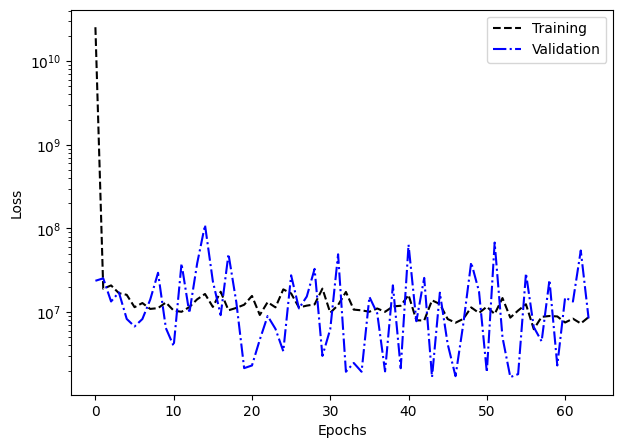

time: 419 ms (started: 2023-06-23 14:36:06 +02:00)


In [43]:
hist_volume = pd.DataFrame(history_volume.history)
hist_volume["epoch"] = history_volume.epoch

# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_volume, f'Learning curve not normalized', True)

In [44]:
y_predicted_volume = model_CNN_volume.predict(X_test) #np.append(model_CNN.predict(X_train), model_CNN.predict(X_test))

5/5 [==============================] - 1s 101ms/step
time: 1.49 s (started: 2023-06-23 14:36:06 +02:00)


In [45]:
print_scores(y_predicted_volume, "Volume")

Volume R²:       82.80%
Volume MAE:     1080.42
Volume MSE:  2219295.65
time: 2.69 ms (started: 2023-06-23 14:36:08 +02:00)


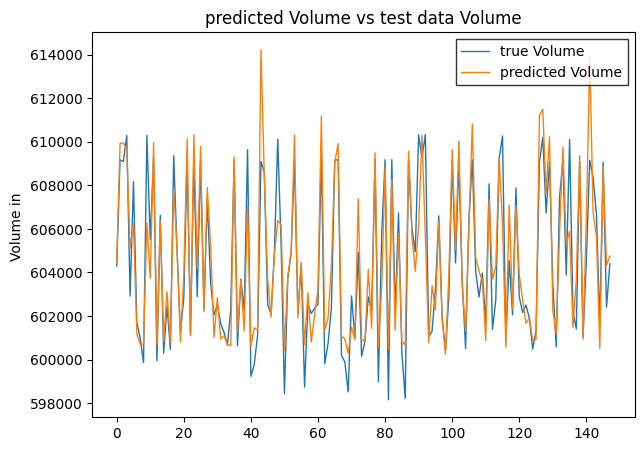

time: 297 ms (started: 2023-06-23 14:36:08 +02:00)


In [46]:
plotting(y_test['Volume'].values, y_predicted_volume, 'Volume in ', True)

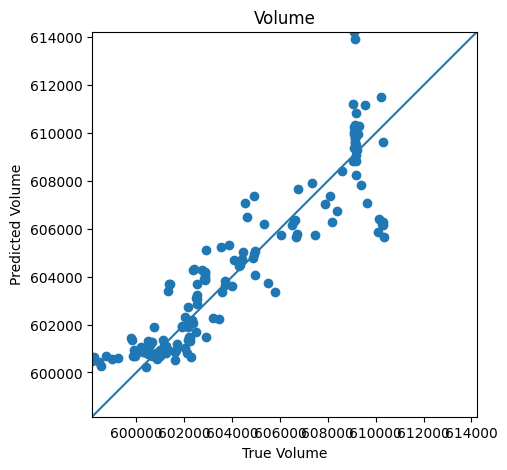

time: 182 ms (started: 2023-06-23 14:36:08 +02:00)


In [47]:
plot_accuracy(y_predicted_volume, "Volume")

### 5.3 Area Prediction

In [48]:
myCheckpoint_area = keras.callbacks.ModelCheckpoint("best_model_area_prediction.h5", save_best_only=True)

model_CNN_area = build_CNN_single_output()

#Training step: Trains the model in silent mode (verbose = 0)
history_area = model_CNN_area.fit(X_train, y_train['Area'].values, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, 
                                callbacks=[myCheckpoint_area, myEarly_stopping])#, verbose=0)
#Calling back the best model:
best_cnn_area = keras.models.load_model("best_model_area_prediction.h5")

Epoch 1/150
300/300 [==============================] - 6s 16ms/step - loss: 80281832.0000 - mae: 4945.8174 - r_square: -0.9503 - val_loss: 15765972.0000 - val_mae: 3341.8296 - val_r_square: 0.6344
Epoch 2/150
300/300 [==============================] - 4s 13ms/step - loss: 6181934.0000 - mae: 2010.9862 - r_square: 0.8498 - val_loss: 7358762.0000 - val_mae: 2385.2141 - val_r_square: 0.8294
Epoch 3/150
300/300 [==============================] - 4s 13ms/step - loss: 3445873.5000 - mae: 1445.7172 - r_square: 0.9163 - val_loss: 2513772.7500 - val_mae: 1303.6543 - val_r_square: 0.9417
Epoch 4/150
300/300 [==============================] - 4s 14ms/step - loss: 2563957.5000 - mae: 1210.6697 - r_square: 0.9377 - val_loss: 1240714.3750 - val_mae: 850.3079 - val_r_square: 0.9712
Epoch 5/150
300/300 [==============================] - 4s 14ms/step - loss: 2015335.7500 - mae: 1104.7700 - r_square: 0.9510 - val_loss: 882870.3125 - val_mae: 739.6400 - val_r_square: 0.9795
Epoch 6/150
300/300 [=========

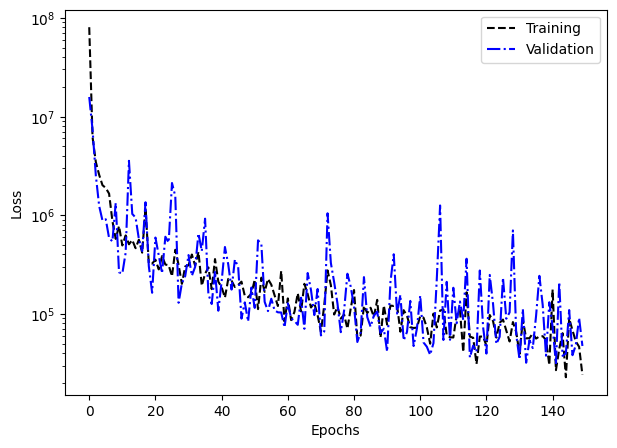

time: 380 ms (started: 2023-06-23 14:46:00 +02:00)


In [49]:
hist_area = pd.DataFrame(history_area.history)
hist_area["epoch"] = history_area.epoch

# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_area, f'Learning curve not normalized', True)

In [50]:
y_predicted_area = model_CNN_area.predict(X_test)

5/5 [==============================] - 0s 33ms/step
time: 705 ms (started: 2023-06-23 14:46:01 +02:00)


In [51]:
print_scores(y_predicted_area, "Area")

Area R²:       99.83%
Area MAE:      188.11
Area MSE:    70753.86
time: 2.06 ms (started: 2023-06-23 14:46:01 +02:00)


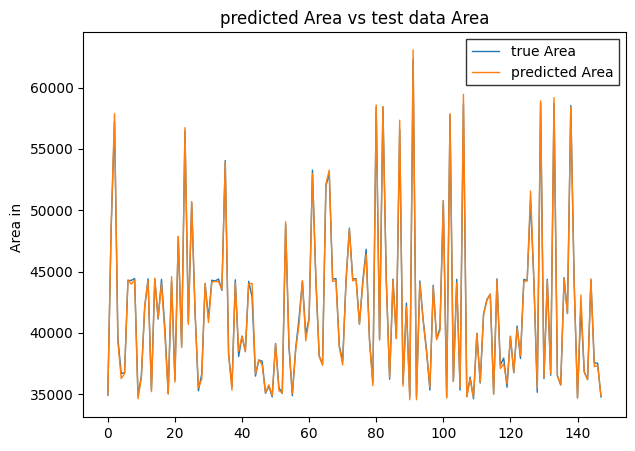

time: 256 ms (started: 2023-06-23 14:46:01 +02:00)


In [52]:
plotting(y_test['Area'].values, y_predicted_area, 'Area in ', True)

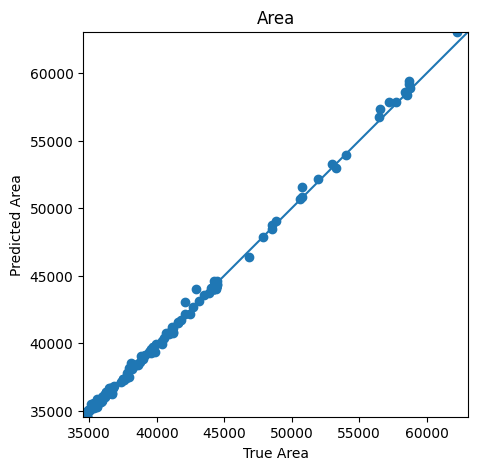

time: 162 ms (started: 2023-06-23 14:46:02 +02:00)


In [53]:
plot_accuracy(y_predicted_area, "Area")

### 5.4 Contact Angle Prediction

In [54]:
myCheckpoint_cangle = keras.callbacks.ModelCheckpoint("best_model_cangle_prediction.h5", save_best_only=True)

model_CNN_cangle = build_CNN_single_output()

#Training step: Trains the model in silent mode (verbose = 0)
history_cangle = model_CNN_cangle.fit(X_train, y_train['Contact Angle'].values, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, 
                                callbacks=[myCheckpoint_cangle, myEarly_stopping])#, verbose=0)
#Calling back the best model:
best_cnn_cangle = keras.models.load_model("best_model_cangle_prediction.h5")

Epoch 1/150
300/300 [==============================] - 6s 15ms/step - loss: 351.9352 - mae: 12.8991 - r_square: 0.6211 - val_loss: 83.5843 - val_mae: 6.1307 - val_r_square: 0.9188
Epoch 2/150
300/300 [==============================] - 4s 13ms/step - loss: 131.2243 - mae: 7.4676 - r_square: 0.8587 - val_loss: 48.1322 - val_mae: 4.6289 - val_r_square: 0.9532
Epoch 3/150
300/300 [==============================] - 4s 13ms/step - loss: 95.3054 - mae: 6.1572 - r_square: 0.8974 - val_loss: 110.0163 - val_mae: 9.4377 - val_r_square: 0.8931
Epoch 4/150
300/300 [==============================] - 4s 13ms/step - loss: 71.7142 - mae: 5.2287 - r_square: 0.9228 - val_loss: 165.8762 - val_mae: 11.4298 - val_r_square: 0.8389
Epoch 5/150
300/300 [==============================] - 4s 13ms/step - loss: 66.0374 - mae: 5.3280 - r_square: 0.9289 - val_loss: 29.1967 - val_mae: 3.9026 - val_r_square: 0.9716
Epoch 6/150
300/300 [==============================] - 4s 13ms/step - loss: 44.3865 - mae: 4.2565 - r_sq

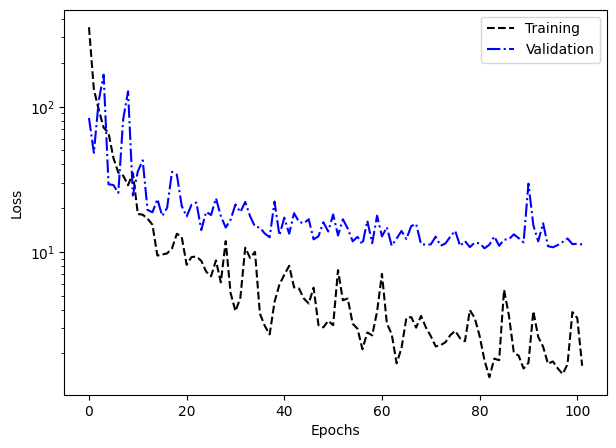

time: 285 ms (started: 2023-06-23 14:52:48 +02:00)


In [55]:
hist_cangle = pd.DataFrame(history_cangle.history)
hist_cangle["epoch"] = history_cangle.epoch

# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_cangle, f'Learning curve not normalized', True)

In [56]:
y_predicted_cangle = model_CNN_cangle.predict(X_test)

5/5 [==============================] - 0s 33ms/step
time: 693 ms (started: 2023-06-23 14:52:48 +02:00)


In [57]:
print_scores(y_predicted_cangle, "Contact Angle")

Contact Angle R²:       97.38%
Contact Angle MAE:        2.98
Contact Angle MSE:       24.27
time: 2.03 ms (started: 2023-06-23 14:52:49 +02:00)


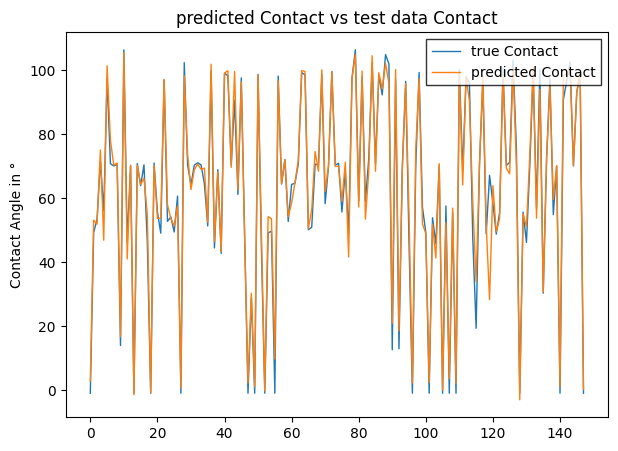

time: 252 ms (started: 2023-06-23 14:52:49 +02:00)


In [58]:
plotting(y_test['Contact Angle'].values, y_predicted_cangle, 'Contact Angle in °', True)

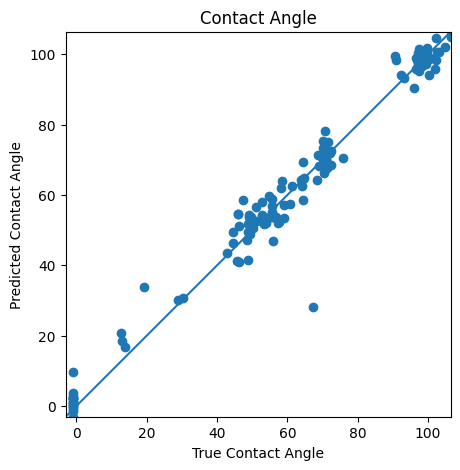

time: 154 ms (started: 2023-06-23 14:52:49 +02:00)


In [59]:
plot_accuracy(y_predicted_cangle, "Contact Angle")

### 5.5 y-position of the  Prediction

In [60]:
myCheckpoint_ycentroid = keras.callbacks.ModelCheckpoint("best_model_ycentroid_prediction.h5", save_best_only=True)

model_CNN_ycentroid = build_CNN_single_output()

#Training step: Trains the model in silent mode (verbose = 0)
history_ycentroid = model_CNN_ycentroid.fit(X_train, y_train['y centroid'].values, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, 
                                callbacks=[myCheckpoint_ycentroid, myEarly_stopping])#, verbose=0)
#Calling back the best model:
best_cnn_ycentroid = keras.models.load_model("best_model_ycentroid_prediction.h5")

Epoch 1/150
300/300 [==============================] - 6s 15ms/step - loss: 99.9849 - mae: 4.3291 - r_square: 0.8044 - val_loss: 2.4820 - val_mae: 1.3423 - val_r_square: 0.9959
Epoch 2/150
300/300 [==============================] - 4s 13ms/step - loss: 1.8617 - mae: 1.0413 - r_square: 0.9964 - val_loss: 0.8024 - val_mae: 0.6699 - val_r_square: 0.9987
Epoch 3/150
300/300 [==============================] - 4s 13ms/step - loss: 1.1070 - mae: 0.7834 - r_square: 0.9978 - val_loss: 4.3105 - val_mae: 1.6079 - val_r_square: 0.9928
Epoch 4/150
300/300 [==============================] - 4s 13ms/step - loss: 3.6236 - mae: 1.4155 - r_square: 0.9929 - val_loss: 7.9515 - val_mae: 2.2813 - val_r_square: 0.9867
Epoch 5/150
300/300 [==============================] - 4s 13ms/step - loss: 6.4857 - mae: 1.7784 - r_square: 0.9873 - val_loss: 6.0287 - val_mae: 2.2317 - val_r_square: 0.9899
Epoch 6/150
300/300 [==============================] - 4s 13ms/step - loss: 2.5025 - mae: 1.1535 - r_square: 0.9951 - v

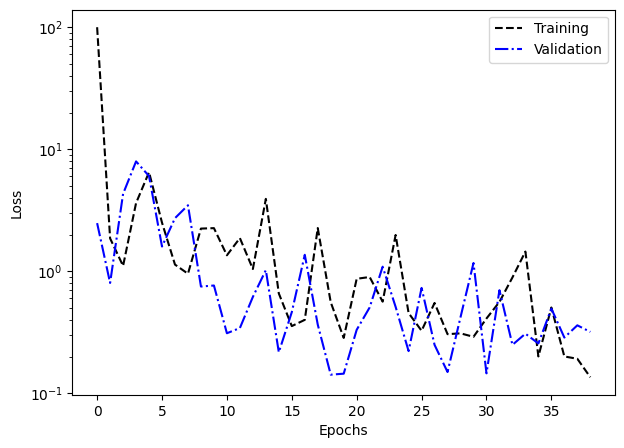

time: 352 ms (started: 2023-06-23 14:55:29 +02:00)


In [61]:
hist_ycentroid = pd.DataFrame(history_ycentroid.history)
hist_ycentroid["epoch"] = history_ycentroid.epoch

# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_ycentroid, f'Learning curve not normalized', True)

In [62]:
y_predicted_ycentroid = model_CNN_ycentroid.predict(X_test)

5/5 [==============================] - 0s 33ms/step
time: 689 ms (started: 2023-06-23 14:55:29 +02:00)


In [63]:
print_scores(y_predicted_ycentroid, "y centroid")

y centroid R²:       99.95%
y centroid MAE:        0.36
y centroid MSE:        0.28
time: 1.98 ms (started: 2023-06-23 14:55:30 +02:00)


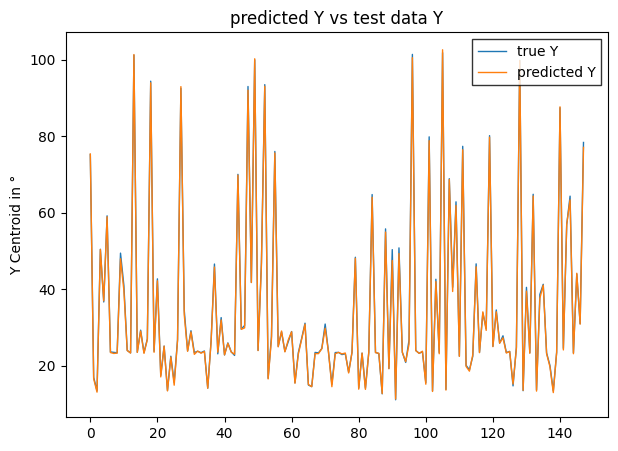

time: 233 ms (started: 2023-06-23 14:55:30 +02:00)


In [64]:
plotting(y_test['y centroid'].values, y_predicted_ycentroid, 'Y Centroid in °', True)

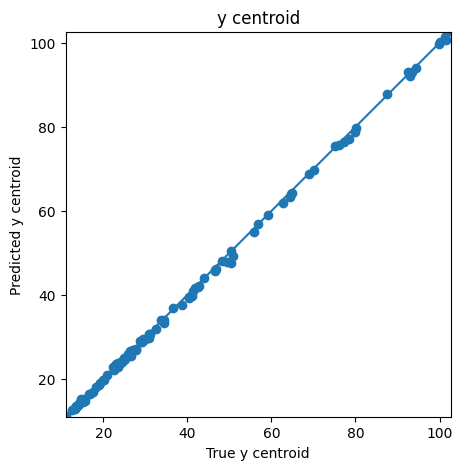

time: 142 ms (started: 2023-06-23 14:55:30 +02:00)


In [65]:
plot_accuracy(y_predicted_ycentroid, "y centroid")

## 6.0 Normalizing the data to use several outputs

For multi output prediction we decided to leave out the x centroid and z centroid coordinate, as we found it to be uninformative because of the droplet being rotationally symmetrical (look at the histogram plots).

In [66]:
#Select relevant data and rescale
featuresToScale = ['Volume','Area','Contact Angle', 'y centroid']
sY = pp.StandardScaler(copy=True)
y_data_rel = pd.DataFrame(np.vstack((y_data['Volume'].values,y_data['Area'].values,y_data['Contact Angle'].values,y_data['y centroid'].values)).T,columns=featuresToScale)
y_data_rel.loc[:,featuresToScale] = sY.fit_transform(y_data_rel[featuresToScale])
#Looking into the statistics again:
y_data_rel.describe()

,Volume,Area,Contact Angle,y centroid
count,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03
mean,-8.340109e-15,-3.459032e-16,2.306021e-16,-1.921684e-17
std,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00
min,-1.672944e+00,-1.144348e+00,-2.170029e+00,-1.002473e+00
25%,-7.733736e-01,-7.549959e-01,-4.836391e-01,-4.718951e-01
50%,-3.311344e-01,-2.468686e-01,1.521032e-01,-4.333881e-01
75%,1.064486e+00,3.716910e-01,1.032604e+00,1.163597e-01
max,1.786444e+00,3.421671e+00,3.450635e+00,3.043535e+00


time: 172 ms (started: 2023-06-23 14:55:30 +02:00)


In [67]:
print('X_min: ',sorted_images.min())
print('X_max: ',sorted_images.max())

X_min:  0.0
X_max:  1.0
time: 1.42 s (started: 2023-06-23 14:55:31 +02:00)


In [68]:
# As the image values are already between 0 and 1 one the X-matrix does not need to be scaled
X = sorted_images
y = y_data_rel
print(y.shape)
X, y = shuffle(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1479, 4)
(1331, 512, 512, 3) (148, 512, 512, 3)
(1331, 4) (148, 4)
time: 6.24 s (started: 2023-06-23 14:55:32 +02:00)


In [69]:
def build_model_CNN():
    # input array shape for the network:
    input_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]
    #Here we will use Sequential API like we did in MLP
    model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform"),
    MaxPooling2D((2, 2)),
    Flatten(),
    
    # Dense(6, activation='relu', kernel_initializer="he_uniform"),
    Dense(y_train.shape[1], activation="linear")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = "mse", metrics=["mae", RSquare()]) 

    return model

time: 862 µs (started: 2023-06-23 14:55:38 +02:00)


In [70]:
#Looking at the graph:
build_model_CNN().summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 256, 256, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 64, 64, 128)     

In [71]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("best_model_norm.h5", save_best_only=True)

myEarly_stopping = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

time: 459 µs (started: 2023-06-23 14:55:38 +02:00)


In [72]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 4

time: 5.12 ms (started: 2023-06-23 14:55:38 +02:00)


In [73]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_CNN = build_model_CNN()

#Training step: Trains the model in silent mode (verbose = 0)
history= model_CNN.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, 
                                callbacks=[myCheckpoint,myEarly_stopping])#, verbose=0)
#Calling back the best model:
model_best= keras.models.load_model("best_model_norm.h5")

Epoch 1/100
300/300 [==============================] - 6s 16ms/step - loss: 32.4468 - mae: 1.2611 - r_square: -31.5045 - val_loss: 0.0956 - val_mae: 0.2095 - val_r_square: 0.8951
Epoch 2/100
300/300 [==============================] - 4s 14ms/step - loss: 0.0781 - mae: 0.1774 - r_square: 0.9227 - val_loss: 0.0496 - val_mae: 0.1498 - val_r_square: 0.9457
Epoch 3/100
300/300 [==============================] - 4s 14ms/step - loss: 0.0538 - mae: 0.1482 - r_square: 0.9467 - val_loss: 0.0439 - val_mae: 0.1477 - val_r_square: 0.9519
Epoch 4/100
300/300 [==============================] - 4s 13ms/step - loss: 0.0420 - mae: 0.1300 - r_square: 0.9584 - val_loss: 0.0636 - val_mae: 0.2024 - val_r_square: 0.9332
Epoch 5/100
300/300 [==============================] - 4s 13ms/step - loss: 0.0364 - mae: 0.1236 - r_square: 0.9639 - val_loss: 0.0485 - val_mae: 0.1593 - val_r_square: 0.9464
Epoch 6/100
300/300 [==============================] - 4s 14ms/step - loss: 0.0309 - mae: 0.1150 - r_square: 0.9693 -

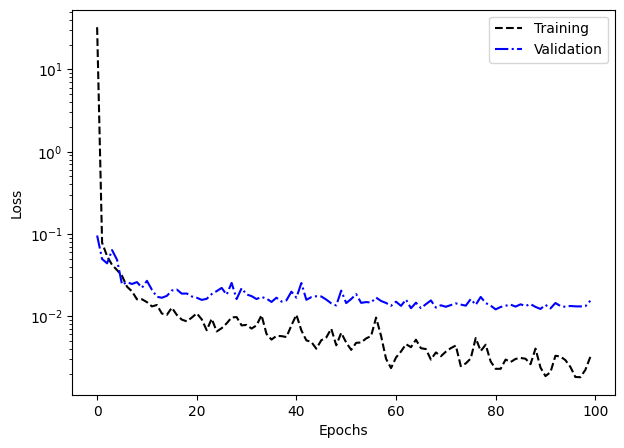

time: 374 ms (started: 2023-06-23 15:02:20 +02:00)


In [74]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist, "Learning curve normalized, two outputs", True)

In [75]:
y_predicted = model_CNN.predict(X_test) #np.append(model_CNN.predict(X_train), model_CNN.predict(X_test))
print(y_predicted.shape)
print(y_test.shape)

y_test = np.array(y_test)

5/5 [==============================] - 0s 33ms/step
(148, 4)
(148, 4)
time: 716 ms (started: 2023-06-23 15:02:20 +02:00)


In [76]:
y_predicted_backTrafo = sY.inverse_transform(y_predicted)
y_test_backTrafo = sY.inverse_transform(y_test)

time: 1.22 ms (started: 2023-06-23 15:02:21 +02:00)


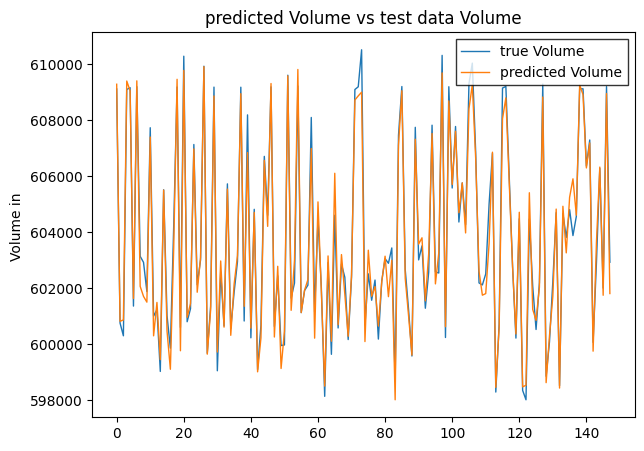

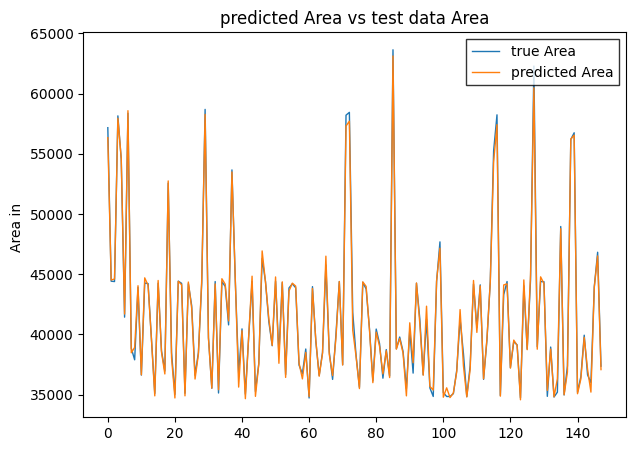

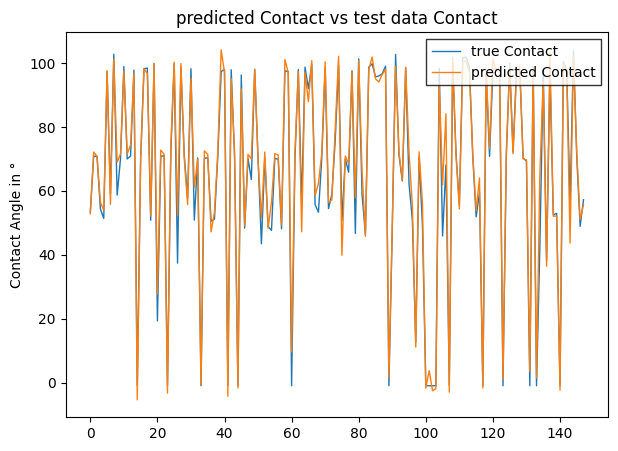

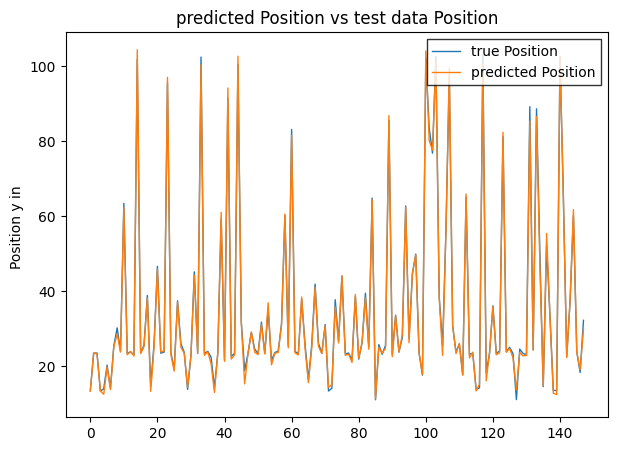

time: 1.02 s (started: 2023-06-23 15:02:21 +02:00)


In [77]:
# compare back-transformed predicted data with back-transformed original data

#Plotting Volume Prediction
plotting(y_test_backTrafo[:,0], y_predicted_backTrafo[:,0], 'Volume in ', True)

#Plotting Area Prediction
plotting(y_test_backTrafo[:,1], y_predicted_backTrafo[:,1], 'Area in ', True)

#Plotting Contact Angle Prediction
plotting(y_test_backTrafo[:,2], y_predicted_backTrafo[:,2],'Contact Angle in °', True)

#Plotting Centroid y Prediction
plotting(y_test_backTrafo[:,3], y_predicted_backTrafo[:,3], 'Position y in ', True)


In [78]:
def visualize_accuracy():
    fig=plt.figure(figsize=(20, 10))
    for i in range(4):
        ax = fig.add_subplot(2,2, i+1)
        plt.scatter( y_test_backTrafo[:,i], y_predicted_backTrafo[:,i] )
        plt.xlabel('True '+ featuresToScale[i])
        plt.ylabel('Predicted '+ featuresToScale[i])
        lims=[min(y_predicted_backTrafo[:,i].min(), y_test_backTrafo[:,i].min()), max(y_predicted_backTrafo[:,i].max(), y_test_backTrafo[:,i].max())]
        plt.xlim(lims), plt.ylim(lims)
        plt.plot(lims, lims)

time: 694 µs (started: 2023-06-23 15:02:22 +02:00)


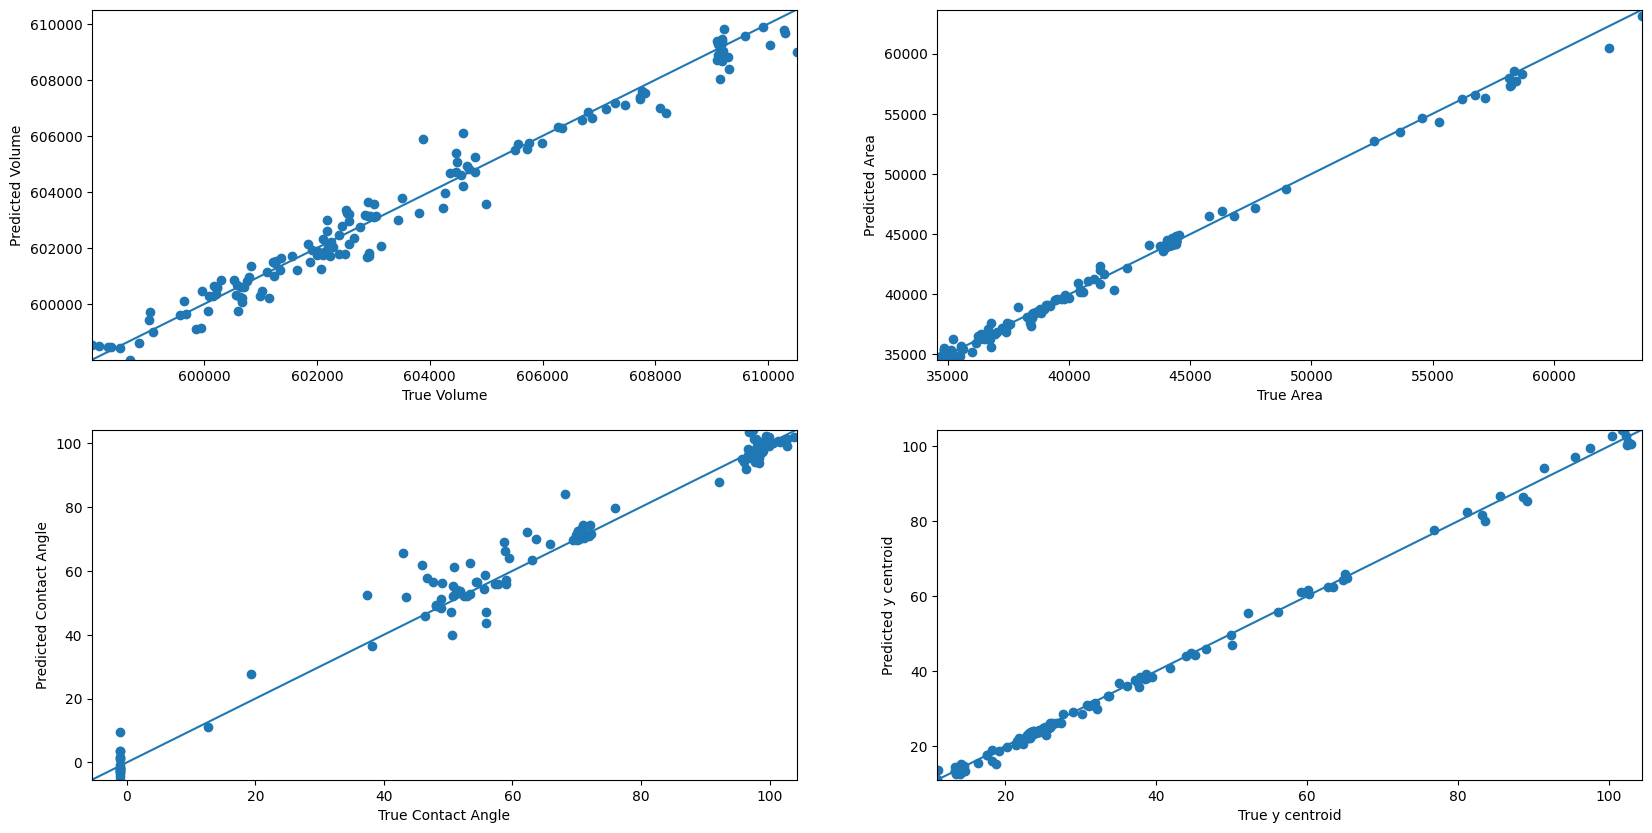

time: 531 ms (started: 2023-06-23 15:02:22 +02:00)


In [79]:
visualize_accuracy()

In [80]:
data = []
for i in range (4):
    score = r2_score(y_test_backTrafo[:,i], y_predicted_backTrafo[:,i])
    mae = mean_absolute_error(y_test_backTrafo[:,i], y_predicted_backTrafo[:,i])
    mse = mean_squared_error(y_test_backTrafo[:,i], y_predicted_backTrafo[:,i])
    data.append([score, mae, mse])
column_labels= ['Volume multi', 'Area multi', 'Contact Angle multi', 'y centroid multi']
temp = pd.DataFrame(np.array(data).T,columns=column_labels)
temp.index = ["R²", "MAE", "MSE"]
score_df[['Volume multi', 'Area multi', 'Contact Angle multi', 'y centroid multi']] = temp

time: 4.63 ms (started: 2023-06-23 15:02:22 +02:00)


In [81]:
stylized_score_df = score_df.copy(deep=True)
stylized_score_df.loc["R²"] = score_df.loc["R²"].apply(lambda x : f"{x*100:.2f}%")
stylized_score_df.loc["MAE"] = score_df.loc["MAE"].apply(lambda x : f"{x:.2f}")
stylized_score_df.loc["MSE"] = score_df.loc["MSE"].apply(lambda x : f"{x:.2f}")

time: 8.78 ms (started: 2023-06-23 15:02:22 +02:00)


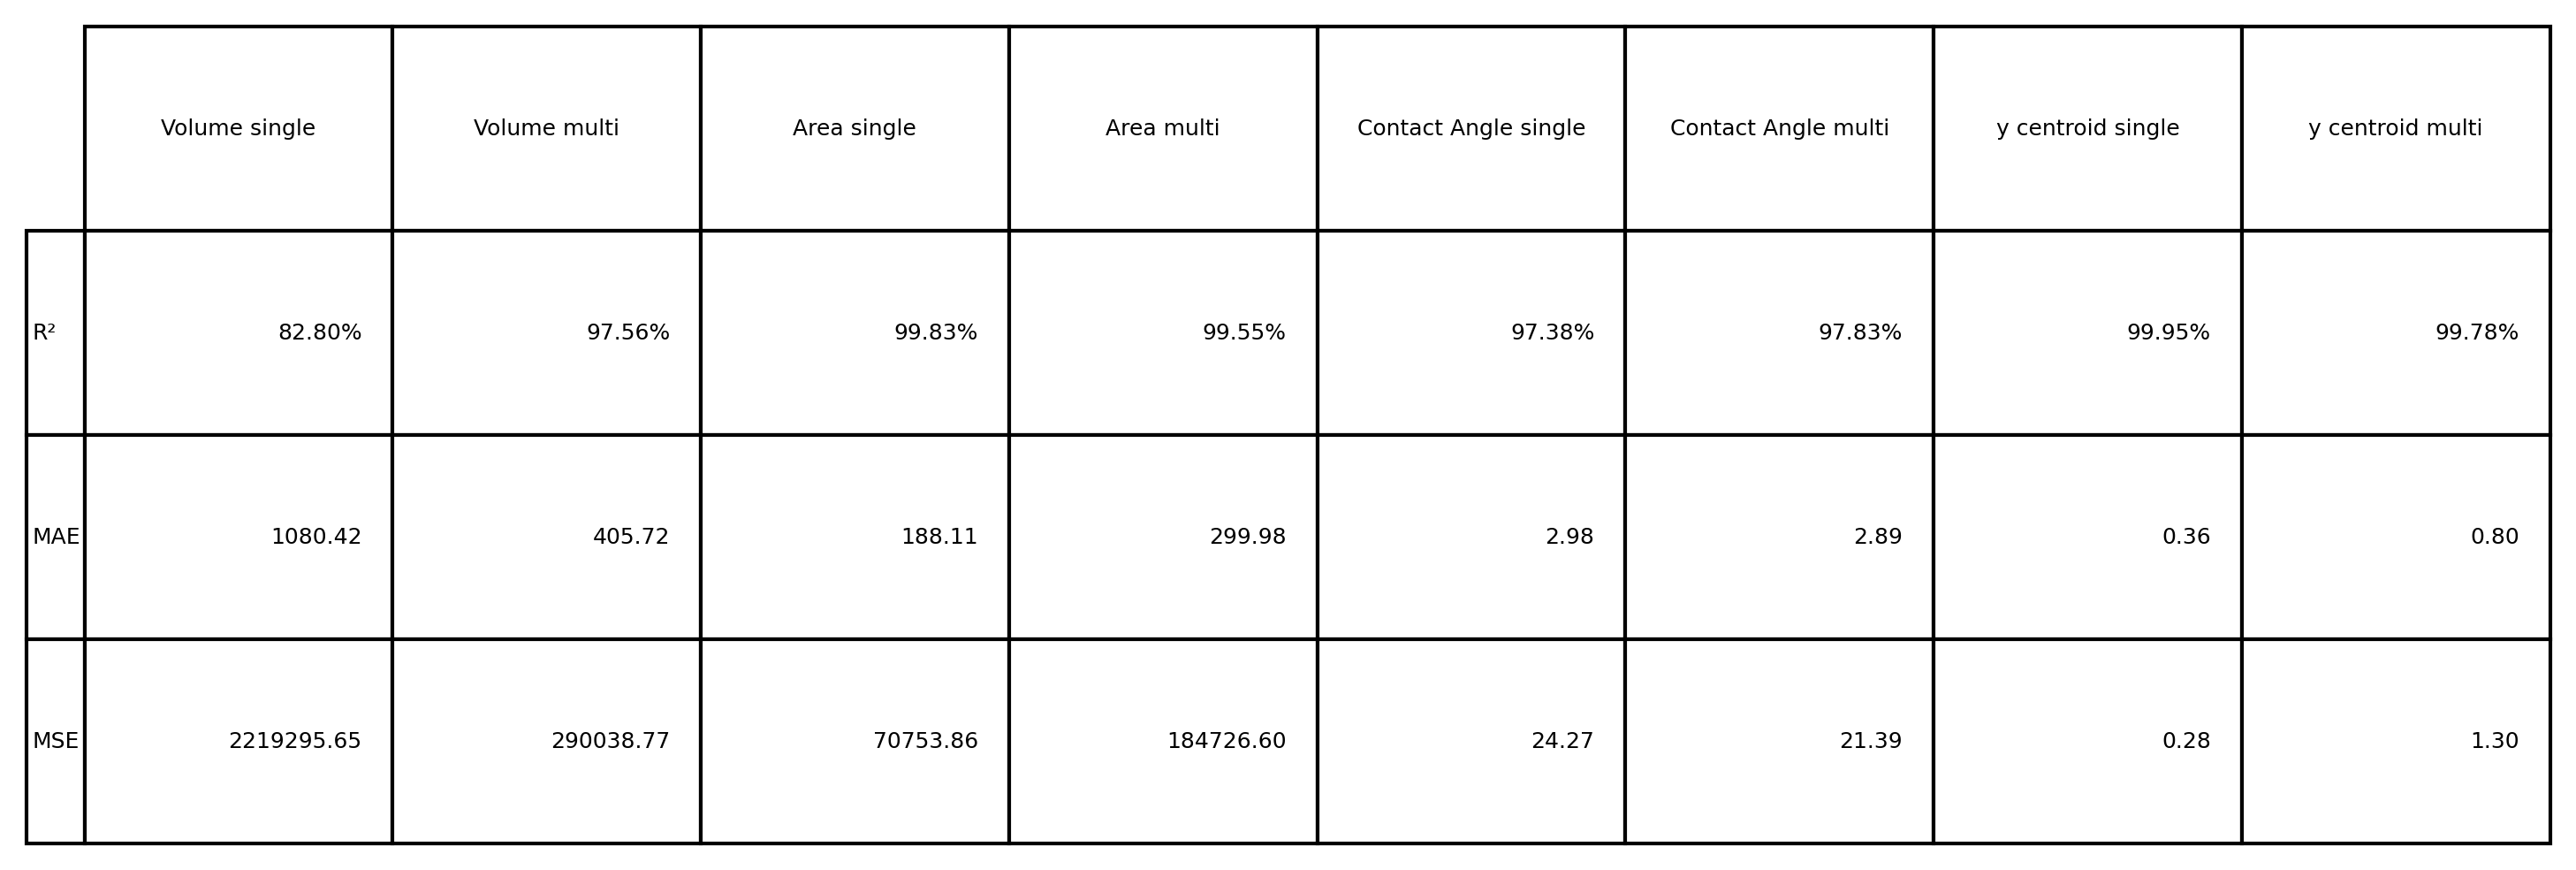

time: 322 ms (started: 2023-06-23 15:02:22 +02:00)


In [82]:
print_stats(stylized_score_df)